In [1]:
# 1. Import Library yang Dibutuhkan
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

In [2]:
# 2. Load Dataset
diabetes_dataset = pd.read_csv('diabetes.csv', sep=';')

In [3]:
# 3. Eksplorasi Dataset
print(diabetes_dataset.head())
print("\n----------\n")
print(diabetes_dataset.shape)  # Ukuran dataset
print("\n----------\n")
print(diabetes_dataset['Outcome'].value_counts())  # Distribusi label

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            2      138             62             35        0  33.6   
1            0       84             82             31      125  38.2   
2            0      145              0              0        0  44.2   
3            0      135             68             42      250  42.3   
4            1      139             62             41      480  40.7   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.127   47        1  
1                     0.233   23        0  
2                     0.630   31        1  
3                     0.365   24        1  
4                     0.536   21        0  

----------

(7231, 9)

----------

Outcome
0    4753
1    2478
Name: count, dtype: int64


kita mau naikkan jumlah data label 1, karna kita mau meningkatkan model kita dalam mendeteksi diabetes, karna harus peka modelnya terhadap data orang diabetes

In [4]:
# 4. Memisahkan Fitur dan Target
X = diabetes_dataset.drop(columns='Outcome', axis=1)
y = diabetes_dataset['Outcome']

In [5]:
# 5. Imputasi Nilai 0 dengan Median untuk Kolom Tertentu
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in columns_with_zeros:
    X[col] = X[col].replace(0, np.nan).fillna(X[col].median())

In [6]:
# 6. Standarisasi Fitur
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
# 7. Membagi Dataset Menjadi Train dan Test Set
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [8]:
# 8. Inisialisasi Model XGBoost dengan Cost-Sensitive Learning
# Tambahkan parameter scale_pos_weight untuk menangani class imbalance
scale_pos_weight = len(Y_train[Y_train == 0]) / len(Y_train[Y_train == 1])  # Rasio kelas mayoritas ke minoritas

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=5,
    learning_rate=0.01,  # Kurangi learning rate
    n_estimators=500,  # Tambahkan jumlah estimators
    scale_pos_weight=scale_pos_weight,  # Penanganan imbalance
    random_state=42
)

In [9]:
# 9. Latih Model
xgb.fit(X_train, Y_train)

C:\Users\walkervalentinus\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [16:39:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [10]:
# 10. Prediksi pada Test Set
Y_pred = xgb.predict(X_test)

In [11]:
# 11. Laporan Klasifikasi
print("XGBoost - Classification Report:\n", classification_report(Y_test, Y_pred))

XGBoost - Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      1426
           1       0.83      0.93      0.88       744

    accuracy                           0.91      2170
   macro avg       0.90      0.92      0.91      2170
weighted avg       0.92      0.91      0.91      2170



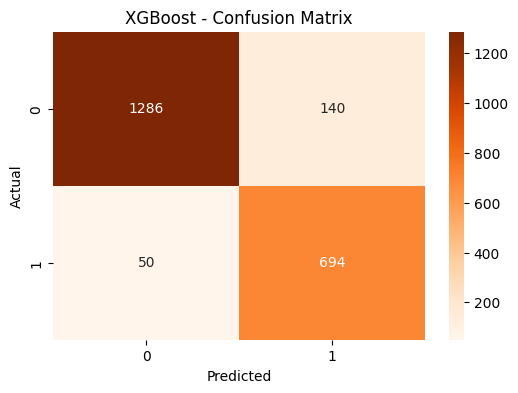

In [12]:
# 12. Visualisasi Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title('XGBoost - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [13]:
# 13. Modifikasi Threshold Prediksi (Opsional)
Y_pred_proba = xgb.predict_proba(X_test)[:, 1]  # Probabilitas kelas 1
threshold = 0.3  # Modifikasi threshold
Y_pred_adjusted = (Y_pred_proba >= threshold).astype(int)

In [14]:
# 14. Laporan Klasifikasi dengan Threshold Baru
print("XGBoost (Threshold 0.3) - Classification Report:\n", classification_report(Y_test, Y_pred_adjusted))

XGBoost (Threshold 0.3) - Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.77      0.87      1426
           1       0.69      0.98      0.81       744

    accuracy                           0.84      2170
   macro avg       0.84      0.88      0.84      2170
weighted avg       0.89      0.84      0.85      2170



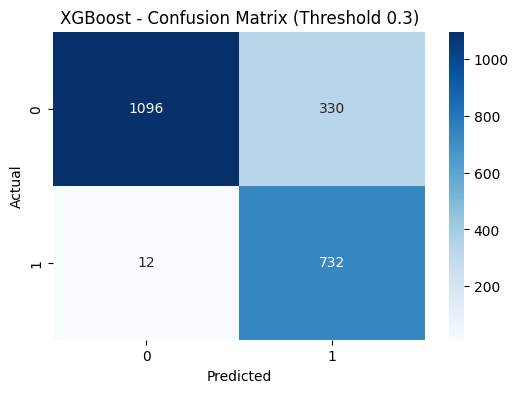

In [15]:
# 15. Visualisasi Confusion Matrix dengan Threshold Baru
cm_adjusted = confusion_matrix(Y_test, Y_pred_adjusted)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost - Confusion Matrix (Threshold 0.3)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [16]:
import pickle

# Simpan model XGBoost ke dalam file pickle
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb, file)

print("Model XGBoost berhasil disimpan ke xgb_model.pkl")

Model XGBoost berhasil disimpan ke xgb_model.pkl


In [17]:
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [18]:
# Contoh input data yang kemungkinan besar memprediksi "Diabetes"
input_data = [[8, 190, 90, 35, 180, 38.5, 1.2, 60]]
# Standarisasi input data
input_data = scaler.transform(input_data)

# Dapatkan probabilitas prediksi
y_prob = xgb.predict_proba(input_data)[:, 1]

# Ubah threshold menjadi 0.3
prediction = (y_prob >= 0.3).astype(int)[0]

if prediction == 1:
    print("Diabetes Detected")
else:
    print("No Diabetes Detected")


Diabetes Detected


C:\Users\walkervalentinus\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
